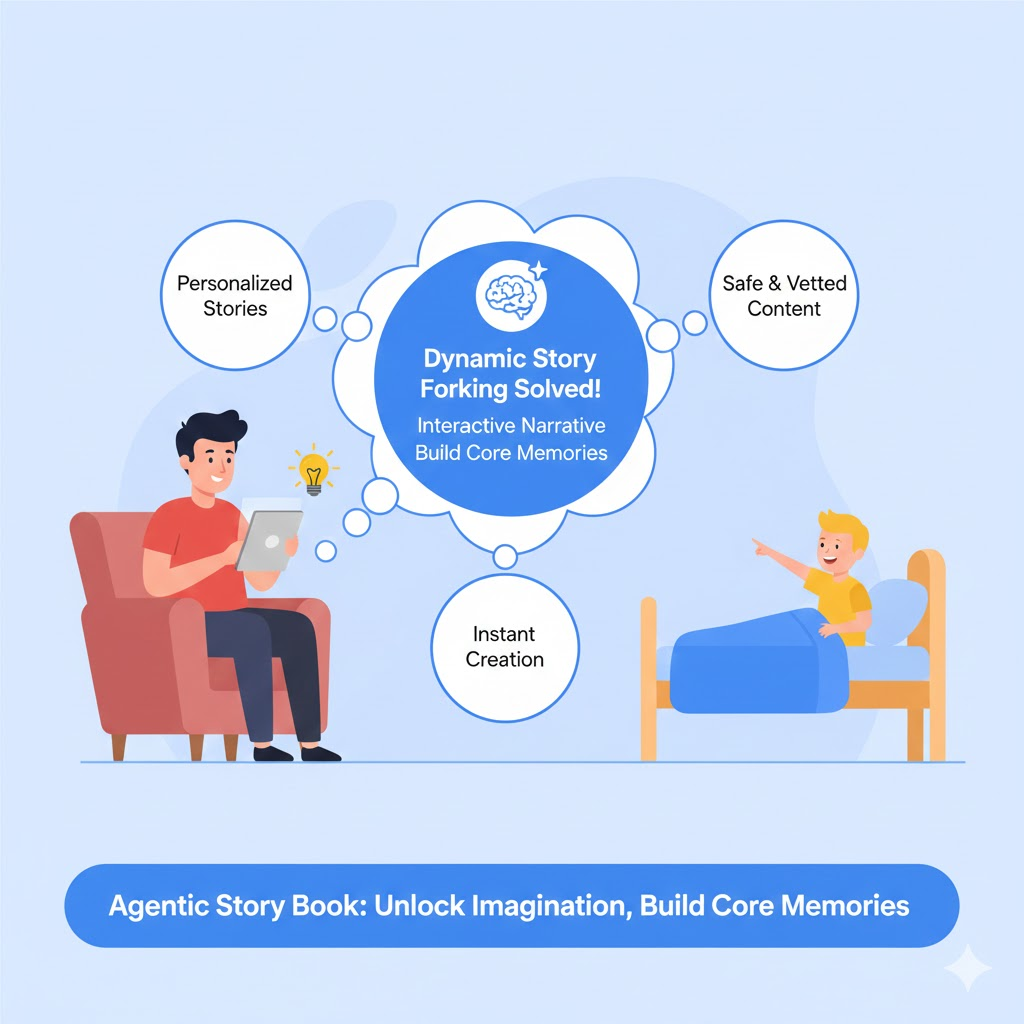

# 📖 Agentic Story Book

## 🎯 Problem: Bridging the "Story Scarcity Gap"

Bedtime stories are a **Core Memory Catalyst**—the single most crucial ritual for parent-child bonding and cognitive development. Yet, this ritual is under threat from two modern challenges:

1.  **Creative Fatigue:** At the end of a long, tiring day, parents face **"End-of-Day Creative Burnout,"** struggling to spontaneously invent a compelling, safe, and original story. This creates a **Story Scarcity Gap** where the desire for quality bonding exceeds the energy available to create it.
2.  **Curiosity Constraint:** Curious children naturally ask boundless, unscripted questions after every plot point ("But why did the dog *really* go home?"). Traditional, static story generation cannot dynamically adapt to this curiosity, forcing parents to invent answers on the fly or risk stifling the child's imaginative flow.

## ✨ Solution: The Agentic Story Book

The **Agentic Story Book** is an orchestrated, multi-agent system designed not just to generate text, but to safeguard and deepen the parent-child bond. It automates creativity, enforces safety, and ensures that every story is dynamically adapted to the child's immediate feedback.

## 🌟 Value Proposition

| Value Focus | Agentic Implementation (The "How") | Impact & Differentiation |
| :--- | :--- | :--- |
| **Safety & Dynamic Adaptability** | **LoopAgent (The "Guardian/Refiner" Cycle):** The `story_refinement_loop` executes a crucial two-step safety and adaptation process. The **Story Guardian Agent** rigorously vets every plot for safety (no fear, violence, or bullying). The **Story Refiner Agent** then incorporates the Guardian's feedback (or the user's iterative input) until the plot is explicitly **APPROVED**. | Guarantees **100% kid-appropriate content** and ensures the system can handle **dynamic story branching** on the fly, transforming a child's question into the next safe, approved plot point. |
| **Convenience & Accessibility** | **Full End-to-End Orchestration:** The `SequentialAgent` pipeline handles research, safety, writing, and archival in a single, autonomous flow. | Solves **Creative Burnout** by reliably delivering a personalized, vetted story, complete with a title and a clean Markdown file, in a single interaction. |
| **Continuity & Personalization (RAG-Enabled Foundation)** | **Persistent Memory Infrastructure:** The application uses `DatabaseSessionService` and the `save_session_to_memory_callback`. This establishes the crucial **memory bank infrastructure**. | The current system is **RAG-Ready**. The persistent memory *enables* a simple next-step feature to retrieve past story data, allowing the system to build a **Custom Story Canon** where the child’s favorite characters and themes recur across sessions, deepening the feeling of shared history. |

***

## 🏗️ Technical Architecture Overview
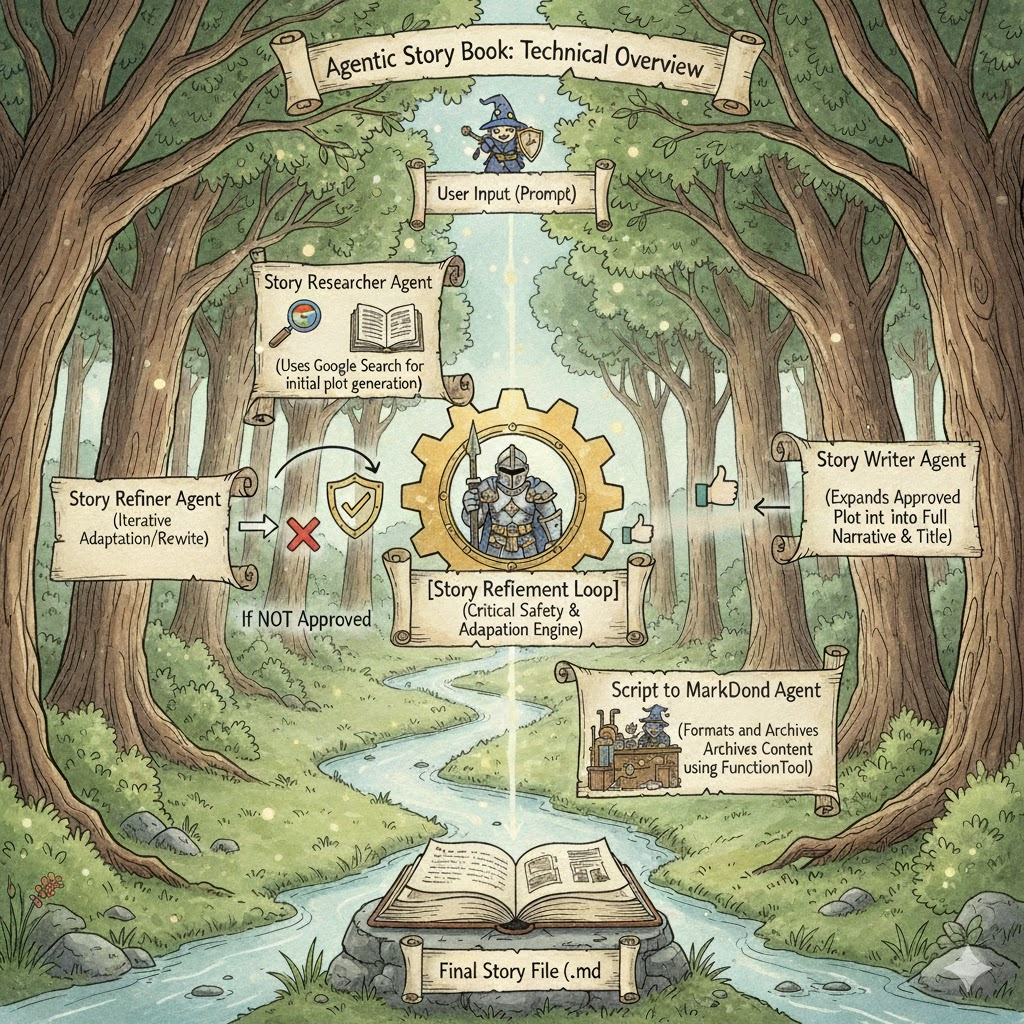

The Agentic Story Book is built around a single **`SequentialAgent`** named `story_creation_pipeline`. This orchestration ensures that the process moves linearly from initial concept to final archival, with safety and refinement cycles embedded along the way.

The pipeline structure is as follows:

1.  **`story_researcher_agent`**: Generates a raw plot outline, leveraging the `Google Search` tool for external inspiration.
2.  **`story_refinement_loop`**: The core safety and refinement engine.
3.  **`story_writer_agent`**: Expands the approved plot into the final script and title.
4.  **`script_to_markdown_agent`**: Creates the final archival artifact.

## 💪 Technical Strengths and Agentic Advantage

The primary strength of the Agentic Story Book is its use of **autonomous, chained decision-making** and the meaningful integration of core ADK concepts:

### Autonomous Self-Correction (LoopAgent)
The **`LoopAgent`** (`story_refinement_loop`) implements an automated **self-correction mechanism** and acts as the system's primary guardian.

* The system does not proceed until the **`story_guardian_agent`** issues the specific exit phrase (`"APPROVED_STORY"`).
* If the plot fails the safety check, the **`story_refiner_agent`** autonomously rewrites the entire plot until the safety criteria are met. This iterative, **closed-loop feedback** is a powerful demonstration of agent autonomy and governance.

### Pipeline Reliability (Guaranteed Output)
To ensure the output is always machine-consumable for the archival step, the system uses **Guaranteed Structured Output** principles:

* The **`story_writer_agent`** is given explicit instructions to return a strict JSON object containing the `story_name` and `final_script`.
* This strong instruction guarantees that the final **`script_to_markdown_agent`** receives clean, predictable data, eliminating parsing errors and ensuring the reliability of the archival artifact every time.

### Memory & State Management
The system achieves statefulness and lays the foundation for advanced memory features:

* **Stateful Sessions:** Using the `DatabaseSessionService` ensures all conversation history and context variables are persisted throughout the user's interaction.
* **Long-Term Memory Foundation:** The `save_session_to_memory_callback` permanently archives the context into the long-term memory bank. This establishes the RAG-ready foundation, allowing the simple insertion of a retrieval step in the future to enable full **cross-session RAG** and a true story canon.

## 🔑 Key Features
The following key concepts of AI Agent systems are demonstrated in this project

1. Sequential agents
2. Loop agents
3. Multi agent architecture
4. Inbuilt tools
5. Function tools
6. MCP tools
7. Agent guardrails
8. Agent observability, plugin based logging
9. Persistent sessions
10. Structured output
11. Callbacks to save session to memory

## 📚 Summary

The **Agentic Story Book** moves from a simple query to a safe, reliable, and personalized final product by leveraging **orchestrated, self-correcting agents**. It simultaneously eliminates parental creative fatigue and empowers the child's imaginative freedom, maximizing the value of the bedtime story ritual and demonstrating advanced agentic design.

# 🚀 Technical Solution
## 🔧 Section 1: Setup
### Configure your Gemini API Key

This notebook uses the [Gemini API](https://ai.google.dev/gemini-api/docs), which requires authentication.

In [ ]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Setup and authentication complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

### Import ADK components

Now, import the specific components you'll need from the Agent Development Kit and the Generative AI library. This keeps your code organized and ensures we have access to the necessary building blocks.

In [ ]:
from google.adk.agents import Agent, SequentialAgent, LoopAgent, LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner, Runner
from google.adk.tools import AgentTool, FunctionTool, google_search
from google.genai import types
from google.adk.sessions import DatabaseSessionService, InMemorySessionService
from google.adk.memory import InMemoryMemoryService
from google.adk.plugins.logging_plugin import (
    LoggingPlugin,
)
from google.adk.apps.app import App
from pydantic import BaseModel, Field
import re
from google.adk.tools.mcp_tool import McpToolset
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams, StdioServerParameters

print("✅ ADK components imported successfully.")

### Configure Retry Options

When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.

In [ ]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

### Helper functions

In [ ]:
# Define helper functions
async def run_session(
    runner_instance: Runner,
    user_queries: list[str] | str = None,
    session_name: str = "default",
):
    print(f"\n ### Session: {session_name}")

    # Get app name from the Runner
    app_name = runner_instance.app_name

    # Attempt to create a new session or retrieve an existing one
    try:
        session = await session_service.create_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )
    except:
        session = await session_service.get_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )

    # Process queries if provided
    if user_queries:
        # Convert single query to list for uniform processing
        if type(user_queries) == str:
            user_queries = [user_queries]

        # Process each query in the list sequentially
        for query in user_queries:
            print(f"\nUser > {query}")

            # Convert the query string to the ADK Content format
            query = types.Content(role="user", parts=[types.Part(text=query)])

            # Stream the agent's response asynchronously
            async for event in runner_instance.run_async(
                user_id=USER_ID, session_id=session.id, new_message=query
            ):
                # Check if the event contains valid content
                if event.content and event.content.parts:
                    # Filter out empty or "None" responses before printing
                    if (
                        event.content.parts[0].text != "None"
                        and event.content.parts[0].text
                    ):
                        print(f"{MODEL_NAME} > ", event.content.parts[0].text)
    else:
        print("No queries!")
print("✅ Helper functions defined.")

## 🤖 Section 2: Agent definitions

In [ ]:
# --- Story Researcher Agent ---
story_researcher_agent = Agent(
    name="story_researcher_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    description="Generates new plot outlines using Google Search to find trending or existing stories and fables that match the user's theme.",
    instruction="""
    You are the Story Researcher. Your goal is to create a 5-sentence plot outline for a child's story.
    
    **Research Strategy:**
    1.  **Use the Google Search tool** to find the 'most famous or trending children's stories' related to the user's theme.
    2.  **Synthesize** a new plot by extracting and adapting the structure and key elements from the search results.
    3.  If you receive feedback from the Guardian, **you MUST incorporate it** to remove any negative elements and increase the plot's safety.
    4.  Your final plot must be a detailed, 5-sentence summary of the story's main action.
    """,
    tools=[google_search],
    output_key="current_story",
)
print("✅ researcher_agent created.")

In [ ]:
# --- Story Guardian Agent ---
story_guardian_agent = Agent(
    name="story_guardian_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
    You are the Guardian Agent. You vet the plot provided in the **most recent input** for **Safety** (no violence, bullying, or fear) and **Grounding** (clear positive moral).
    
    **CRITICAL:** Assume the source material came from the unfiltered web. Your safety scrutiny must be extremely high. You are the ONLY guardrail.
    
    Evaluate the story's plot and appropriateness to kids.
    - if it's well written, adheres to user requested features and suitable for kids, you MUST respond with the exact phrase: "APPROVED_STORY"
    - Otherwise, provide 2/3 specific, actionable suggestions for improving the story
    """,
    output_key="vetted_story",
)
print("✅ guardian_agent created.")

In [ ]:
# This is the function that the Story Refiner Agent will call to exit the loop.
def story_exit_loop():
    """Call this function ONLY when the guardian_agent has returned 'APPROVED_STORY', indicating the story is finished and no more changes are needed."""
    return {"status": "APPROVED_STORY", "message": "Story approved. Exiting story refinement loop."}
print("✅ story exit_loop function created.")

In [ ]:
# --- Story Refiner Agent ---
story_refiner_agent = Agent(
    name="story_refiner_agent",
    model=Gemini(model="gemini-2.5-flash-lite",retry_options=retry_config),
    instruction="""
    You are a story refiner. Your task is to analyze the feedback from the Guardian.
    
    Story Draft: {current_story}
    Guardian Feedback: {vetted_story}
    
    - IF the Guardian Feedback is EXACTLY "APPROVED_STORY", you MUST call the `story_exit_loop` function and nothing else.
    - OTHERWISE, rewrite the Story Draft (the entire 5-sentence summary) to fully incorporate the feedback from the Guardian.
    """,
    # This overwrites the state with either the new plot or the function call's output
    output_key="current_story", 
    tools=[
        FunctionTool(story_exit_loop)
    ], 
)
print("✅ story_refiner_agent created.")

In [ ]:
# The LoopAgent runs the Guardian (to check) and the Refiner (to rewrite/exit).
story_refinement_loop = LoopAgent(
    name="story_refinement_loop",
    sub_agents=[story_guardian_agent, story_refiner_agent],
    max_iterations=3,  # Prevents infinite loops
)

In [ ]:
# --- Pydantic Schema for Script Writer Output ---
class StoryWithSanitizedPath(BaseModel):
    """
    The structured output containing the story details, including the
    sanitized path segment for the file manager.
    """
    story_name: str = Field(description="The original, human-readable name of the story.")
    final_script: str = Field(description="The full Markdown content of the story script.")
    clean_path_segment: str = Field(
        description="The sanitized, URL-safe segment derived from the story_name, e.g., 'the-case-of-the-crystal-critters'."
    )

def sanitize_story_name(story_name: str) -> str:
    """
    Sanitizes the story name into a safe, Linux-compliant directory name 
    by replacing all problematic characters with hyphens.
    """
    sanitized = story_name.lower()
    sanitized = re.sub(r'["\':?!,]', '', sanitized)
    sanitized = re.sub(r'[\s/\\_]+', '-', sanitized)
    sanitized = sanitized.strip('-')
    return sanitized if sanitized else "default-story-folder"

sanitize_tool = FunctionTool(sanitize_story_name)
print("✅ Sanitization Tool created.")

# --- Agent Definition: Script Writer Agent ---
story_writer_agent = Agent(
    model="gemini-2.5-flash-lite",
    name="story_writer_agent",
    description="Generates a story script and sanitizes the name for filesystem use.",
    instruction="""
    Your task is to generate the final story content ('final_script'), and then 
    prepare the output for the file manager.

    1. **Generate Content**: Create the 'story_name' (a short, catchy title) and the 'final_script' content.
    
    2. **Shorten and Sanitize Path (CRITICAL)**: 
        a. **Truncate:** Take the 'story_name' and **extract only the first four words**. You MUST stop after the fourth word. Call this [SHORT_TITLE].
        b. **Sanitize:** Call the `sanitize_story_name` tool with the **[SHORT_TITLE]**. You MUST remember the clean result as [CLEAN_SEGMENT].
    
    3. **Final Output (STRICT ENFORCEMENT):** Generate the final output JSON that strictly conforms to the `StoryWithSanitizedPath` schema.
        * The 'clean_path_segment' MUST be set to the short, sanitized [CLEAN_SEGMENT] result from Step 2.
    """,
    tools=[
        sanitize_tool
    ],
    output_schema=StoryWithSanitizedPath,
)

In [ ]:
# --- Pydantic Schema ---
class StoryOutput(BaseModel):
    """The structured output containing the path and content of the saved story."""
    story_path: str = Field(
        description="The absolute path (including the file name) where the Markdown script was successfully saved."
    )
    story_script: str = Field(
        description="The full content of the story script that was generated and saved."
    )

# --- MCP Filesystem Toolset (External) ---
KAGGLE_WORKING_DIR = "/kaggle/working" 
MCP_CONNECTION_TIMEOUT = 60

def create_filesystem_toolset():
    """Creates an McpToolset instance connected to the server-filesystem."""
    print(f"Configuring MCP Filesystem Server with access to: {KAGGLE_WORKING_DIR}")
    
    server_params = StdioServerParameters(
        command='npx', 
        args=[
            "-y", 
            "@modelcontextprotocol/server-filesystem",
            KAGGLE_WORKING_DIR, 
        ],
    )
    
    connection_params = StdioConnectionParams(
        server_params=server_params,
        timeout_seconds=MCP_CONNECTION_TIMEOUT 
    )
    return McpToolset(
        connection_params=connection_params,
    )
print("✅ MCP Toolset created.")

# --- Agent Definition --
script_to_markdown_agent = Agent(
    model="gemini-2.5-flash-lite",
    name="script_to_markdown_agent",
    description="Dedicated agent to safely create a directory and write a file using sequential MCP tool calls. This agent's only goal is the side-effect of file creation.",
    instruction=f"""
    Your input contains 'final_script' and the 'clean_path_segment' (e.g., 'tom-and-jerry-the-spice-harmony-saga').
    Your sole task is to execute the directory and file creation sequence and then immediately STOP.
    
    **CRITICAL RULE: You MUST execute the file operations. DO NOT generate any final JSON, text, or use the set_model_response tool.**

    1. **Construct Paths**: Use the provided 'clean_path_segment' to construct the following variables:
        * **DIRECTORY PATH**: `{KAGGLE_WORKING_DIR}/[clean_path_segment]`.
        * **FULL FILE PATH**: `{KAGGLE_WORKING_DIR}/[clean_path_segment]/[clean_path_segment].md`.
    
    2. **Action 1 (Create Directory - MANDATORY):** **ONLY** call **`create_directory`** once. The path argument MUST be the **DIRECTORY PATH**. Wait for the success result.
        
    3. **Action 2 (Write File - CRITICAL):** **ONLY** upon receiving the **SUCCESS** response from the `create_directory` call (Step 2), you **MUST** call **`write_file`**. DO NOT call any other tool.
        * The path argument MUST be the **FULL FILE PATH**. 
        * The content argument MUST be the 'final_script' content from your input.

    4. **Final Action:** After the successful `write_file` call, you **MUST** stop execution immediately.
    """,
    tools=[
        create_filesystem_toolset() # Must be the MCP toolset containing create_directory and write_file
    ]
)

print("✅ ScriptToMarkdownAgent defined successfully.")

In [ ]:
# Root agent and app definitions
APP_NAME = "story_guardian_app"
USER_ID = "user-1"  # User
MODEL_NAME = "gemini-2.5-flash-lite"

async def save_session_to_memory_callback(callback_context):
    """Saves the session state to long-term memory after the pipeline finishes."""
    print("💾 Pipeline Complete. Saving session to Memory Service...")
    if hasattr(callback_context._invocation_context, 'memory_service'):
        await callback_context._invocation_context.memory_service.add_session_to_memory(
            callback_context._invocation_context.session
        )
print("✅ Memory Callback created.")

# The root agent is a SequentialAgent that defines the overall workflow:
root_agent = SequentialAgent(
    name="story_creation_pipeline",
    sub_agents=[
        story_researcher_agent, 
        story_refinement_loop, 
        story_writer_agent,
        script_to_markdown_agent
    ],
    after_agent_callback=save_session_to_memory_callback
)
print("✅ Story creation pipeline created")

# --- Create the App Wrapper ---
story_guardian_app = App(
    name=APP_NAME,
    root_agent=root_agent,
    plugins=[LoggingPlugin()]
)
print("✅ Story Guardian App created")

## 🗒️ Section 3: Session, Memory and Runner definitions

In [ ]:
# Create Session Service
# SQLite database will be created automatically
db_url = "sqlite:///story_guardian.db"  # Local SQLite file
session_service = DatabaseSessionService(db_url=db_url)
print("✅ Upgraded to persistent sessions!")

# Handles memory
memory_service = (
    InMemoryMemoryService()
)  # ADK's built-in Memory Service for development and testing, in prod this will be replaced by persistent memory and then used for RAG

# --- Create Runner with the App ---
runner = Runner(
    app=story_guardian_app,
    session_service=session_service,
    memory_service=memory_service
)
print("✅ Runner initialized with App")

## 👷 Section 4: Agents at work

In [ ]:
await run_session(
    runner,
    [ "tell a silly story about two dogs and a cat that are best friends", 
     # "tell a sequel for that story where the cat is the famous Tom from Tom and Jerry"
     # "tell a funny story which is less than 100 words for a kid"
    ],
    "session-1",
)

# ✅ Results

**Guardrails / Safety**

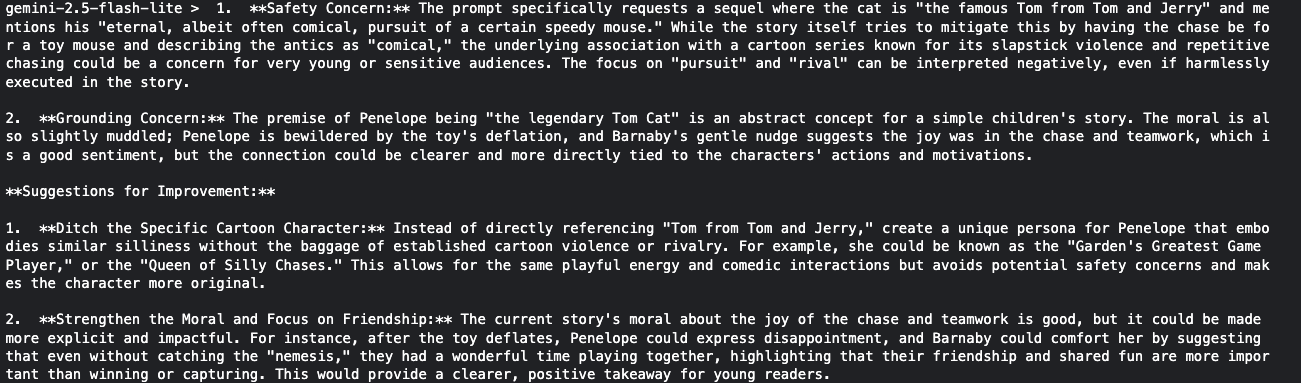

# ✌️ Next Steps
1. Multimodal Storytelling: Integrate image generation using nano banana and TTS abilities into the pipeline to get a better story book.
2. Human-in-the-Loop Approval: Introduce an explicit HandOff step after the story_refinement_loop to pause the agent and request human approval.
3. GCP integration : deploy the agentic system to GCP and use GCS for artifact storage and Vertex AI services
4. Implement a Custom Story Canon (RAG): use a RAG Agent that queries saved history to intelligently weave in beloved characters from past stories into new narratives.